In [1]:
import torch

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device} device.')

Working on cuda device.


In [2]:
import kagglehub
import shutil
import os

# Pobranie danych
download_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print(f'Path to dataset files: {download_path}\n')

# Przeniesienie danych do odpowiedniego miejsca
train_path = f'{download_path}/seg_train'
test_path = f'{download_path}/seg_test'
destination_path = '/content'

if os.path.isdir('/content/seg_train') or os.path.isdir('/content/seg_test'):
  print('Directory already exists.\n')
else:
  shutil.move(src=train_path, dst=destination_path)
  shutil.move(src=test_path, dst=destination_path)
  print(f'Moved dataset files to {destination_path}')

train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'

100%|██████████| 346M/346M [00:03<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2

Moved dataset files to /content


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Załadowanie danych do DF
train_data = []
test_data = []
class_to_idx = {}
class_names = []

# Załadowanie danych treningowych
for idx, class_name in enumerate(os.listdir(train_path)):
  class_path = os.path.join(train_path, class_name)
  class_to_idx[class_name] = idx
  class_names.append(class_name)

  for image_file in os.listdir(class_path):
    if image_file.endswith('.jpg'):
      image_path = os.path.join(class_path, image_file)
      train_data.append([image_path, class_name])

df_train = pd.DataFrame(train_data, columns=['image_path', 'class'])

# Podział danych na train i validate
train_data_split, val_data_split = train_test_split(df_train,
                                                    test_size=0.2,
                                                    stratify=df_train['class'],
                                                    random_state=42)

df_train_split = pd.DataFrame(train_data_split, columns=['image_path', 'class'])
df_val_split = pd.DataFrame(val_data_split, columns=['image_path', 'class'])

# Załadowanie danych testowych
for idx, class_name in enumerate(os.listdir(test_path)):
  class_path = os.path.join(test_path, class_name)

  for image_file in os.listdir(class_path):
    if image_file.endswith('.jpg'):
      image_path = os.path.join(class_path, image_file)
      test_data.append([image_path, class_name])

df_test = pd.DataFrame(test_data, columns=['image_path', 'class'])

# Przedstawienie rozmiarów podziału
print(f'Rozmiar zbioru treningowego: {len(df_train_split)}')
print(f'Rozmiar zbioru walidacyjnego: {len(df_val_split)}')
print(f'Rozmiar zbioru testowego: {len(df_test)}')

Rozmiar zbioru treningowego: 11227
Rozmiar zbioru walidacyjnego: 2807
Rozmiar zbioru testowego: 3000


In [4]:
# Kilka przykładów danych w zbiorze treningowym
df_train_split.head(5)

,image_path,class
3291,/content/seg_train/seg_train/buildings/18546.jpg,buildings
6299,/content/seg_train/seg_train/sea/16647.jpg,sea
9868,/content/seg_train/seg_train/glacier/4276.jpg,glacier
10034,/content/seg_train/seg_train/glacier/17777.jpg,glacier
6918,/content/seg_train/seg_train/forest/14353.jpg,forest


In [5]:
# Kilka przykładów danych w zbiorze walidacyjnym
df_val_split.head(5)

,image_path,class
8043,/content/seg_train/seg_train/forest/7932.jpg,forest
10946,/content/seg_train/seg_train/glacier/8374.jpg,glacier
13318,/content/seg_train/seg_train/mountain/10574.jpg,mountain
2761,/content/seg_train/seg_train/buildings/13395.jpg,buildings
4333,/content/seg_train/seg_train/buildings/16733.jpg,buildings


In [6]:
# Kilka przykładów danych w zbiorze testowym
df_test.head(5)

,image_path,class
0,/content/seg_test/seg_test/street/21400.jpg,street
1,/content/seg_test/seg_test/street/22314.jpg,street
2,/content/seg_test/seg_test/street/23758.jpg,street
3,/content/seg_test/seg_test/street/24161.jpg,street
4,/content/seg_test/seg_test/street/23779.jpg,street


In [7]:
# Sprawdzenie dostępnych nazw etykiet
class_names

['street', 'buildings', 'sea', 'forest', 'glacier', 'mountain']

In [8]:
# Zobaczenie dostępnych etykiet i odpowiadających im wartościom indeksom
class_to_idx

{'street': 0,
 'buildings': 1,
 'sea': 2,
 'forest': 3,
 'glacier': 4,
 'mountain': 5}

In [9]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.v2 import Compose

# Stwórzenie klasy CustomDataset w celu załadowania zbioru danych
class CustomDataset(Dataset):
  def __init__(self, dataframe: pd.DataFrame, class_to_idx: dict, transform: Compose=None):
    self.dataframe = dataframe
    self.class_to_idx = class_to_idx
    self.transform = transform

  def __len__(self) -> int:
    return len(self.dataframe)

  def __getitem__(self, idx) -> tuple:
    row = self.dataframe.iloc[idx]
    image_path = row['image_path']
    label = self.class_to_idx[row['class']]

    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, label

In [10]:
from torchvision.transforms.v2 import ToTensor, Normalize, ToDtype, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter

# Stworzenie transformacji dla kazdego datasetu
transform_train = Compose([
    Resize((150, 150)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToDtype(torch.float)
])

transform_val = Compose([
    Resize((150, 150)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToDtype(torch.float)
])

transform_test = Compose([
    Resize((150, 150)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToDtype(torch.float)
])

# Stworzenie datasetow przy uzyciu klasy CustomDataset
train_dataset = CustomDataset(dataframe=df_train_split, class_to_idx=class_to_idx, transform=transform_train)
validation_dataset = CustomDataset(dataframe=df_val_split, class_to_idx=class_to_idx, transform=transform_val)
test_dataset = CustomDataset(dataframe=df_test, class_to_idx=class_to_idx, transform=transform_test)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
from torch.utils.data import DataLoader

# Stworzenie dataloaderow
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

validation_dataloader = DataLoader(dataset=validation_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [12]:
# Stworzenie CNN
from torch import nn

class CNN(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=82944, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)

    return x

In [13]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.6 MB/s eta 0:00:00


In [14]:
from torchmetrics import Accuracy

# Ustawienie hiperparametrów
input_shape = 3 # kanały RGB
hidden_units = 64
num_classes = len(class_to_idx)  # Ilość etykiet
lr = 0.001

# Stworzenie modelu
model = CNN(input_shape=input_shape, hidden_units=hidden_units, output_shape=num_classes).to(device)

# Wybranie loss_fn, optimizera i accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
accuracy_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [15]:
import torchvision

# Stworzenie funkcji train
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               accuracy_fn: Accuracy,
               device: torch.device):
  '''
  Performs a training with model trying to learn on data_loeader.
  '''

  train_loss, train_acc = 0, 0

  model.train()

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    logits = model(X)
    preds = logits.argmax(dim=1)

    # 2. Calculate loss and accuracy
    loss = loss_fn(logits, y)
    train_loss += loss

    train_acc += accuracy_fn(preds, y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc*100:.2f}%\n')

  return train_loss, train_acc


In [16]:
# Stworzenie funkcji test
def val_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn: Accuracy,
              device: torch.device):
  '''
  Performs a validating loop step on model going over data_loader.
  '''

  val_loss, val_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X_val, y_val in dataloader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      # 1. Forward pass
      logits = model(X_val)
      preds = logits.argmax(dim=1)

      # 2. Calcualte loss and accuracy
      loss = loss_fn(logits, y_val)
      val_loss += loss

      val_acc += accuracy_fn(preds, y_val)

    val_loss /= len(dataloader)
    val_acc /=len(dataloader)

    print(f'Val loss: {val_loss:.5f} | Val acc: {val_acc*100:.2f}%\n')

    return val_loss, val_acc

In [17]:
# Stworzenie funkcji test
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn: Accuracy,
              device: torch.device):
  '''
  Performs a testing loop step on model going over data_loader.
   '''

  test_loss, test_acc = 0, 0
  preds_list = []
  targets_list = []

  model.eval()

  with torch.inference_mode():
    for X_test, y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      logits = model(X_test)
      preds = logits.argmax(dim=1)

      # Zbieramy wszystkie predykcje do stworzenia confusion matrix
      preds_list.append(preds)
      targets_list.append(y_test)

      # 2. Calcualte loss and accuracy
      loss = loss_fn(logits, y_test)
      test_loss += loss

      test_acc += accuracy_fn(preds, y_test)

    test_loss /= len(dataloader)
    test_acc /=len(dataloader)

    return test_loss, test_acc, preds_list, targets_list

    print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc*100:.2f}%\n')


In [18]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Stworzenie petli treningowej i testowej
epochs = 15

epochs_count = []

train_loss_count = []
val_loss_count = []

train_acc_count = []
val_acc_count = []

start = timer()

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch + 1}\n----------')

  train_loss, train_acc = train_step(model=model,
                                     dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device)

  val_loss, val_acc = val_step(model=model,
                               dataloader=validation_dataloader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)

  epochs_count.append(epoch)

  train_loss_count.append(float(train_loss.cpu()))
  train_acc_count.append(float(train_acc.cpu()))

  val_loss_count.append(float(val_loss.cpu()))
  val_acc_count.append(float(val_acc.cpu()))

end = timer()
total_time = end-start

print(f'\nTotal time: {total_time:.2f} s.')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1
----------
Train loss: 1.09104 | Train acc: 56.46%

Val loss: 0.90116 | Val acc: 63.42%

Epoch: 2
----------
Train loss: 0.82389 | Train acc: 68.02%

Val loss: 0.77822 | Val acc: 72.15%

Epoch: 3
----------
Train loss: 0.70405 | Train acc: 73.27%

Val loss: 0.61897 | Val acc: 76.87%

Epoch: 4
----------
Train loss: 0.61130 | Train acc: 77.56%

Val loss: 0.58063 | Val acc: 79.51%

Epoch: 5
----------
Train loss: 0.56205 | Train acc: 79.50%

Val loss: 0.53512 | Val acc: 80.83%

Epoch: 6
----------
Train loss: 0.51918 | Train acc: 81.22%

Val loss: 0.52261 | Val acc: 81.71%

Epoch: 7
----------
Train loss: 0.48991 | Train acc: 82.19%

Val loss: 0.48891 | Val acc: 82.31%

Epoch: 8
----------
Train loss: 0.46561 | Train acc: 83.55%

Val loss: 0.53047 | Val acc: 81.31%

Epoch: 9
----------
Train loss: 0.44220 | Train acc: 84.09%

Val loss: 0.49186 | Val acc: 83.40%

Epoch: 10
----------
Train loss: 0.43113 | Train acc: 84.74%

Val loss: 0.49970 | Val acc: 82.69%

Epoch: 11
---------

In [19]:
# Ostateczne testowanie
test_loss, test_acc, preds_list, targets_list = test_step(model=model,
                                                          dataloader=test_dataloader,
                                                          loss_fn=loss_fn,
                                                          accuracy_fn=accuracy_fn,
                                                          device=device)

print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc*100:.2f}.')

Test loss: 0.48751 | Test acc: 84.24.


In [20]:
import matplotlib.pyplot as plt

# Funkcja do wizualizacji loss
def plot_loss(epochs, train_loss, val_loss, test_loss):
  plt.figure(figsize=(10, 7))

  plt.plot(epochs, train_loss, label='Train loss')
  plt.plot(epochs, val_loss, label='Validation loss')

  last_epoch = epochs[-1]
  plt.scatter(last_epoch, test_loss, color='green', label='Final test loss', marker='x')

  plt.title('Train, validation and testloss values')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()

# Funkcja do wizuzalizacji accuracy
def plot_acc(epochs, train_acc, val_acc, test_acc):
  plt.figure(figsize=(10, 7))

  plt.plot(epochs, train_acc, label='Train accuracy')
  plt.plot(epochs, val_acc, label='Validation accuracy')

  last_epoch = epochs[-1]
  plt.scatter(last_epoch, test_acc, color='green', label='Final test accuracy', marker='x')

  plt.title('Train, validation and test accuracy %')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

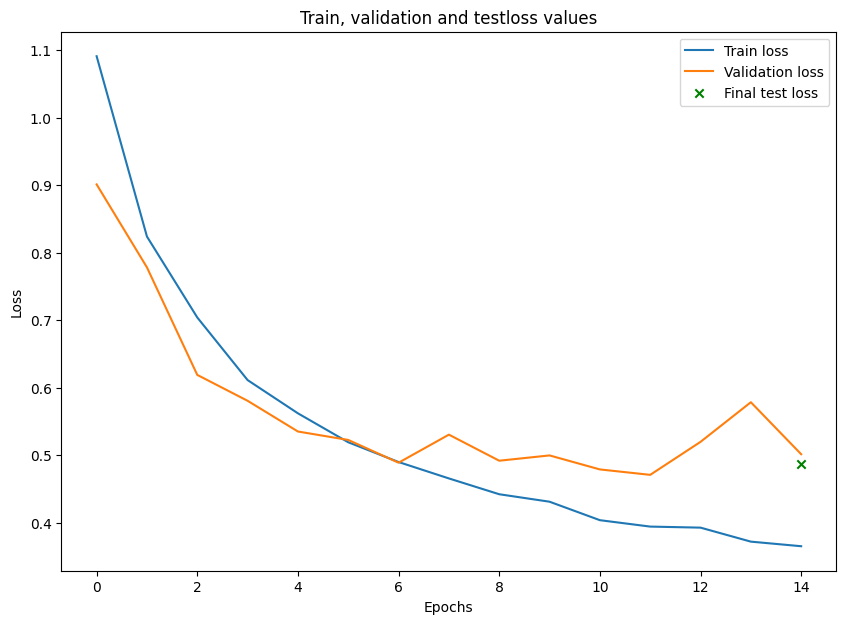

In [21]:
# Wizualizacja loss
plot_loss(epochs=epochs_count, train_loss=train_loss_count, val_loss=val_loss_count, test_loss=test_loss.cpu())

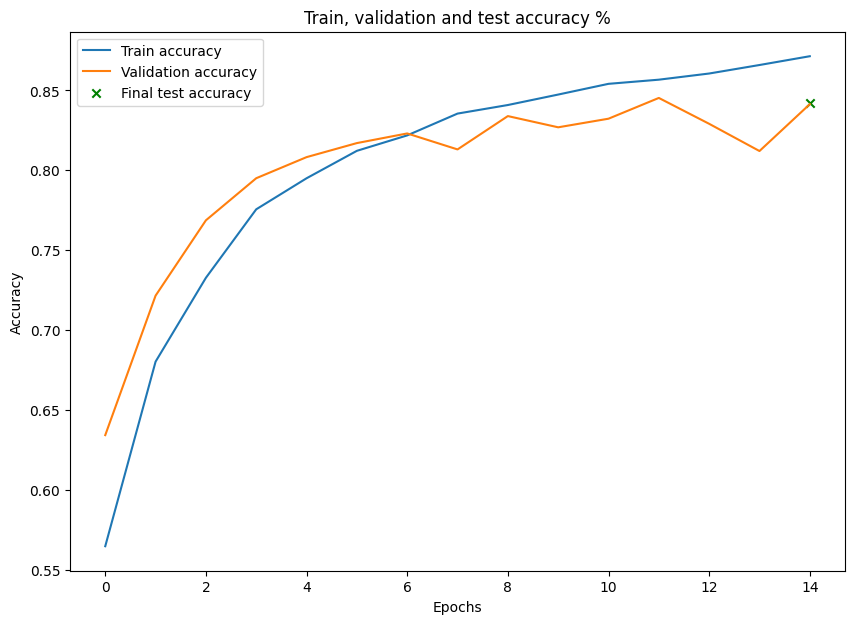

In [22]:
# Wizualizacja accuracy
plot_acc(epochs=epochs_count, train_acc=train_acc_count, val_acc=val_acc_count, test_acc=test_acc.cpu())

In [23]:
from torchmetrics import ConfusionMatrix

# Przygotowanie Confusion Matrix

# Połączenie wszystkich tensorow i elementow w jeden tensor osobno dla preds i targets
preds_tensor = torch.cat(preds_list).cpu()
targets_tensor = torch.cat(targets_list).cpu()

# Stworzenie ConfusionMatrix
confusion_matrix = ConfusionMatrix(num_classes=num_classes, task='multiclass')
confusion_matrix_tensor = confusion_matrix(preds=preds_tensor, target=targets_tensor)

In [24]:
!pip install mlxtend

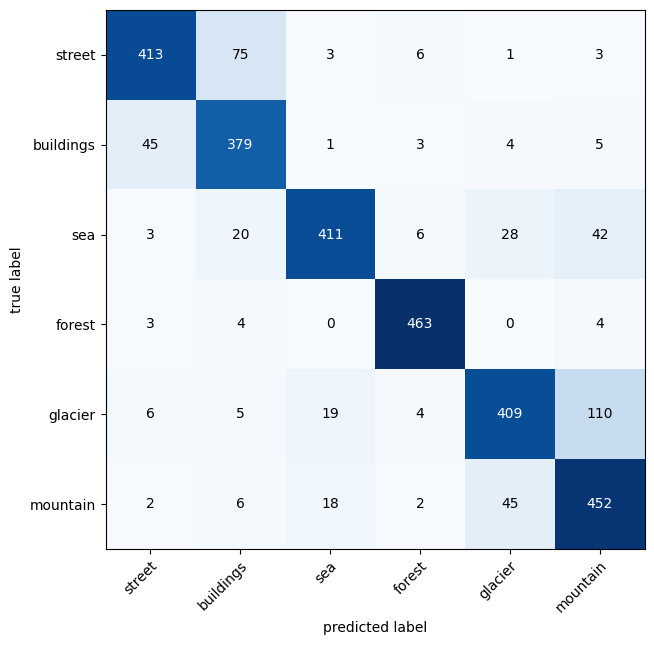

In [25]:
from mlxtend.plotting import plot_confusion_matrix

# Wizualizacja ConfusionMatrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.numpy(), class_names=class_names, figsize=(10, 7))

In [26]:
# Zapisanie modelu
model_name = 'model.pth'
torch.save(obj=model.state_dict(), f=model_name)